In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import plugins
import datetime
import numpy as np
from sklearn.metrics import mean_squared_error,r2_score

### Machine learning models
from sklearn.linear_model import LinearRegression

## 1. Reading the input data

In [2]:
chicago = pd.read_csv("Crimes_-_2001_to_present.csv")
ch_10 = chicago[chicago.Year > 2010]

## 2. Data Quality Check

### 2.1 Checking the number of NA values per column

In [3]:
ch_10.isna().sum()

ID                          0
Case Number                 1
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     4355
Arrest                      0
Domestic                    0
Beat                        0
District                    1
Ward                       32
Community Area            213
FBI Code                    0
X Coordinate            16589
Y Coordinate            16589
Year                        0
Updated On                  0
Latitude                16589
Longitude               16589
Location                16589
dtype: int64

In [4]:
### Looking that the NA values that we will need to impute

### Following variables are imputed
# District                    
# Ward
# Community Area

### Imputing the following might not be very helpful from the modeling standpoint
# - Case Number, Location Description, X/Y Co-ordindates and Latitude/Longitude

### 2.2 Imputing 
#### Imputing District variable

In [92]:
### Creating the list of Community Areas and the Districts with most occurences
district_community = ch_10.groupby(['District','Community Area'],as_index = False)['ID'].count()
district_community = district_community.sort_values(['Community Area','ID'],ascending = False)

### List of the Community Areas for the missing districts
### To be made sure that there are no NA community area
missing_dist_comm = ch_10[ch_10.District.isna()]['Community Area']

## Getting the maximum occuring district value for each of the Community Areas
required_index_vals = [district_community[district_community['Community Area'] == each].index[0] \
                       for each in missing_dist_comm.values]

### Filling the NA district values with the best District value best on the Community Area
ch_10.loc[ch_10.District.isna(),'District'] = district_community.loc[required_index_vals,].District.values

#### Imputing Ward variable 

In [93]:
### Creating the list of Community Areas and the Ward with most occurences
ward_community = ch_10.groupby(['Ward','Community Area'],as_index = False)['ID'].count()
ward_community = ward_community.sort_values(['Community Area','ID'],ascending = False)

### List of the Community Areas for the missing districts
### To be made sure that there are no NA community area
missing_ward_comm = ch_10[ch_10.Ward.isna()]['Community Area']

## Getting the maximum occuring Ward value for each of the Community Areas
required_index_vals = [ward_community[ward_community['Community Area'] == each].index[0] \
                       for each in missing_ward_comm.values if not np.isnan(each)]

### Filling the NA ward values with the best Ward value best on the Community Area
ch_10.loc[ch_10.Ward.isna(),'Ward'] = ward_community.loc[required_index_vals,].Ward.values

### 2.3 Outlier check by analyzing distributions

#### 2.3.2 Analysing Districts

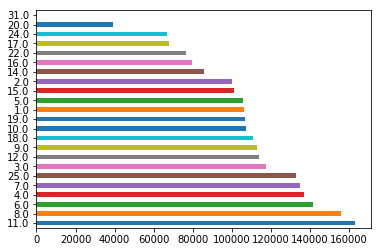

In [7]:
ch_10.District.value_counts().plot(kind  = 'barh')

##### District number 31 has very less observations (less than 1% of the other lowest observation) in comparison with other districtions.

###### Removing District 31

#### 2.3.2 Analysing Year

In [8]:
ch_10.Year.value_counts()

2011    351770
2012    335954
2013    307084
2014    275261
2016    268924
2017    267975
2018    265674
2015    264029
2019     26296
Name: Year, dtype: int64

##### Let us use 2018 and 2019 data as a part of the test dataset

## 3. Creating additional Features from Date variable

In [94]:
ch_top10 = ch_10

ch_top10.loc[:,'Month']  = ch_top10.Date.apply(lambda x: x[0:2])
ch_top10.loc[:,'Day']  = ch_top10.Date.apply(lambda x: x[3:5])
ch_top10.loc[:,'Yr']  = ch_top10.Date.apply(lambda x: x[6:10])

ch_top10.loc[:,'Hour'] = ch_top10.Date.apply(lambda x: x[11:13])
ch_top10.loc[:,'Minute'] = ch_top10.Date.apply(lambda x: x[14:16])
ch_top10.loc[:,'AM_PM'] = ch_top10.Date.apply(lambda x: x[-2:])

## 4. Defining Response Variable

In [95]:
### Setting equal weightage to all the crimes
top_5_crimes = ch_10['Primary Type'].value_counts()[0:7].index

ch_top10.loc[:,'Cops_required'] = 2
ch_top10.loc[ch_top10['Primary Type'].isin(top_5_crimes),'Cops_required'] = 4

### This number should be modified based on the number of cops required for each crime

#### 4.1 Aggregating the data at Year-Month-Day-Hour-District level

In [11]:
model_data = ch_top10.groupby(['Year','Month','Day','District'],as_index = False)['Cops_required'].sum()
model_data = model_data.groupby(['Year','Month','District'],as_index = False)['Cops_required'].mean()

## Removing February since we do not have the entire month
model_data = model_data[~((model_data.Year == 2019) & (model_data.Month == '02'))]

#### Looking at the Monthly pattern for a district

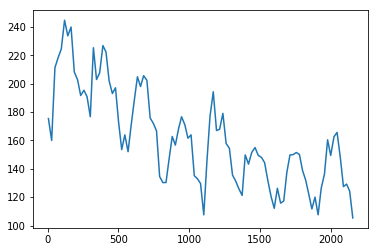

In [12]:
model_data[model_data.District == 7].Cops_required.plot()

## 5. Applying Machine Learning Algorithms

### 5.1 Train-Test split

In [13]:
### Since it is a time series data, we do not do a random split - but a sequential split

test_index = model_data[(model_data.Year == 2019) | \
                        ((model_data.Year == 2018) & (model_data.Month.isin(['10','11','12'])))].index

valid_index = model_data[((model_data.Year == 2018) & (model_data.Month.isin(['07','08','09'])))].index


train_index = model_data[~model_data.index.isin(np.concatenate((test_index,valid_index)))].index

### Getting train and test data
train_data = model_data[model_data.index.isin(train_index)]
valid_data = model_data[model_data.index.isin(valid_index)]
test_data = model_data[model_data.index.isin(test_index)]

print("Shape of the training data is",train_data.shape)
print("Shape of the validation data is",valid_data.shape)
print("Shape of the test data is",test_data.shape)

Shape of the training data is (2018, 4)
Shape of the validation data is (67, 4)
Shape of the test data is (88, 4)


#### Preparing custom dataset to predict new months

In [14]:
###### Preparing datasets to predict future months #######
###### Customer made for predicting new months #########
test_month1 = test_data[(test_data.Year == 2019) & (test_data.Month == '01')].copy()
test_month2 = test_data[(test_data.Year == 2019) & (test_data.Month == '01')].copy()
test_month3 = test_data[(test_data.Year == 2019) & (test_data.Month == '01')].copy()
test_month4 = test_data[(test_data.Year == 2019) & (test_data.Month == '01')].copy()

test_month1.Month = 2
test_month2.Month = 3
test_month3.Month = 4
test_month4.Month = 5

test_future = pd.concat([test_month1,test_month2,test_month3,test_month4],axis = 0)
test_future.reset_index(drop = True,inplace = True)

### 5.2 Linear Regression

In [15]:
## Initializing linear model
linear_model = LinearRegression()

## Fitting the model
linear_model.fit(train_data.drop(['Cops_required'],axis = 1),train_data['Cops_required'])

## Predicting the results
linear_train_predict = linear_model.predict(train_data.drop(['Cops_required'],axis = 1))
linear_test_predict = linear_model.predict(test_data.drop(['Cops_required'],axis = 1))
linear_valid_predict = linear_model.predict(valid_data.drop(['Cops_required'],axis = 1))

### Printing RMSE for train and test data
print("Linear Regression (RMSE): ")
print("Training data: ",np.sqrt(mean_squared_error(train_data['Cops_required'].values, linear_train_predict)))
print("Validation data: ",np.sqrt(mean_squared_error(valid_data['Cops_required'].values, linear_valid_predict)))
print("Test data: ",np.sqrt(mean_squared_error(test_data['Cops_required'].values, linear_test_predict)))

print("\n")
### Printing R squared for train and test data
print("Linear Regression (R2): ")
print("Training data: ",(r2_score(train_data['Cops_required'].values, linear_train_predict)))
print("Validation data: ",(r2_score(valid_data['Cops_required'].values, linear_valid_predict)))
print("Test data: ",(r2_score(test_data['Cops_required'].values, linear_test_predict)))

Linear Regression (RMSE): 
Training data:  37.60984272004147
Validation data:  38.97313331397128
Test data:  28.84611838858667


Linear Regression (R2): 
Training data:  0.3188979294093309
Validation data:  0.012632054490786526
Test data:  0.19051722575269692


### 5.3 XG Boost

In [16]:
## Importing required packages
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import mean_squared_error, r2_score

## Converting all the data to numeric data types
train_data = train_data.apply(lambda x: pd.to_numeric(x,errors = 'coerce'))
test_data = test_data.apply(lambda x: pd.to_numeric(x,errors = 'coerce'))
valid_data = valid_data.apply(lambda x: pd.to_numeric(x,errors = 'coerce'))
future_data = test_future.apply(lambda x: pd.to_numeric(x,errors = 'coerce'))

### Preparing xgb data objects to feed into the model
dtrain = xgb.DMatrix(train_data.drop(['Cops_required'],axis = 1),label = train_data['Cops_required'])
dvalid = xgb.DMatrix(valid_data.drop(['Cops_required'],axis = 1),label = valid_data['Cops_required'])
dtest = xgb.DMatrix(test_data.drop(['Cops_required'],axis = 1),label = test_data['Cops_required'])
dfuture = xgb.DMatrix(future_data.drop(['Cops_required'],axis = 1),label = future_data['Cops_required'])

#dtrain = xgb.DMatrix(train_data['Cops_required'])

##### Training the model

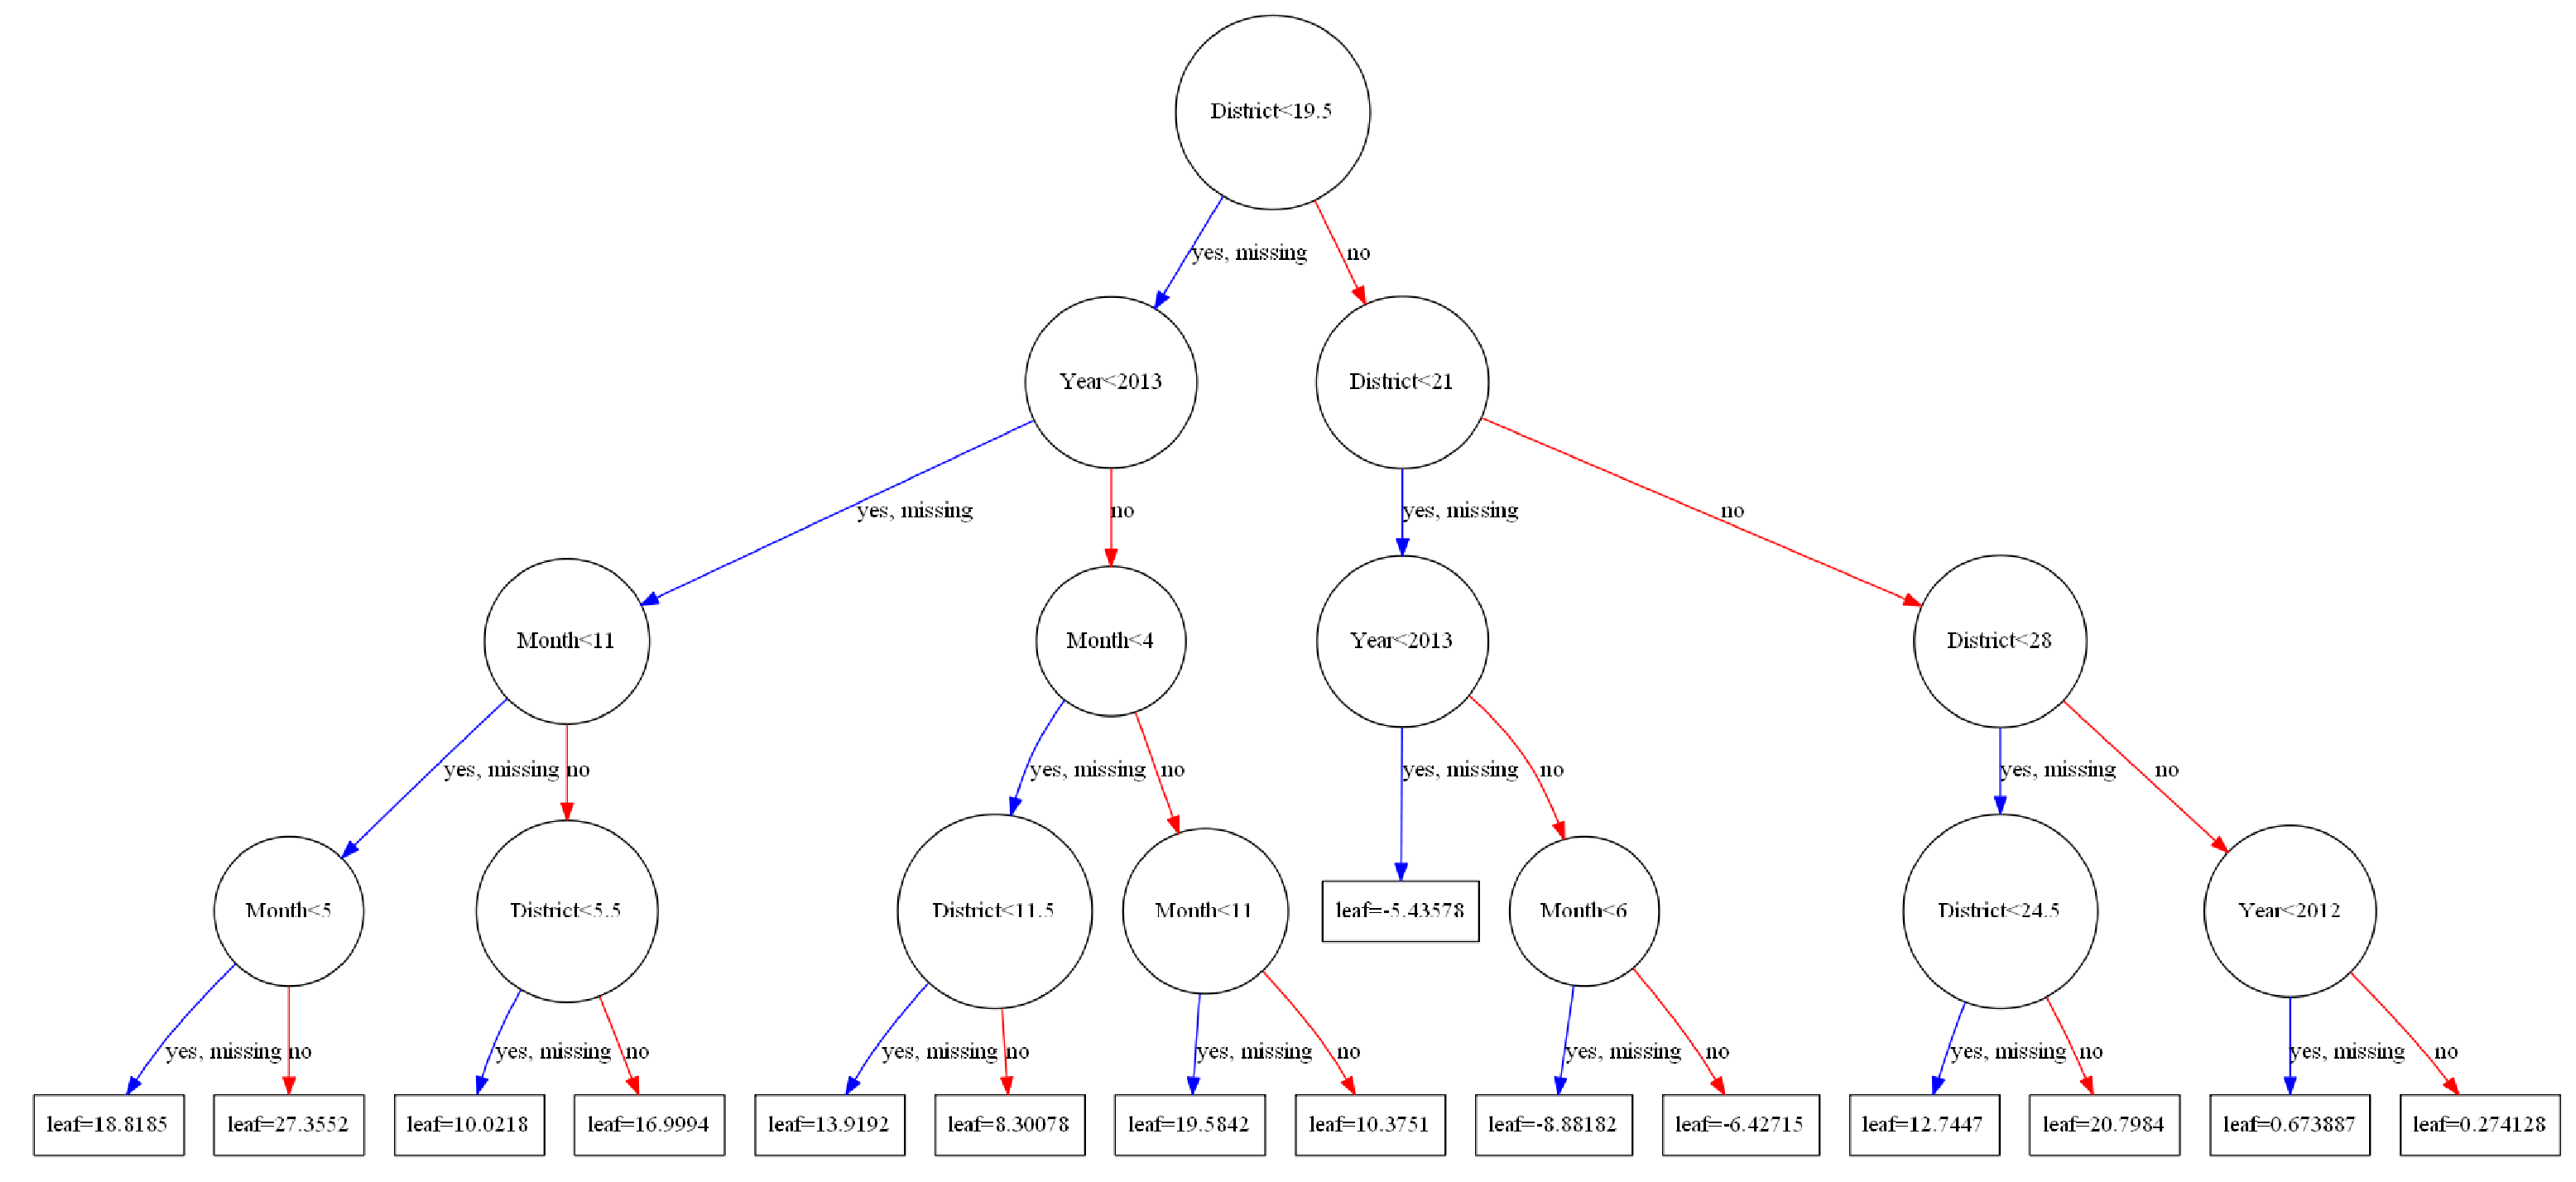

In [53]:
### Initializing the hyperparameters
param = {'max_depth': 4, 'eta':0.5, 'silent':1, 'objective':'reg:linear'}

### Training the model with the selected hyperparameters
bst = xgb.train(param, dtrain, 100)
plt.rcParams["figure.figsize"] = [55,27]
plot_tree(bst,num_trees=2)

#### Validation

In [54]:
### Residual Sum of Squares
### Checking the prediction on validaton dataset
print("XG Boost (RMSE): ")

print("Training data: ",np.sqrt(mean_squared_error(train_data['Cops_required'].values, bst.predict(dtrain))))
print("Validation data: ",np.sqrt(mean_squared_error(valid_data['Cops_required'].values, bst.predict(dvalid))))
print("Test data: ",np.sqrt(mean_squared_error(test_data['Cops_required'].values, bst.predict(dtest))))


print("\n")
### Printing R squared for train and test data
print("Linear Regression (R2): ")
print("Training data: ",(r2_score(train_data['Cops_required'].values, bst.predict(dtrain))))
print("Validation data: ",(r2_score(valid_data['Cops_required'].values, bst.predict(dvalid))))
print("Test data: ",(r2_score(test_data['Cops_required'].values, bst.predict(dtest))))

XG Boost (RMSE): 
Training data:  5.435948856291569
Validation data:  6.579005599329948
Test data:  9.461437548651952


Linear Regression (R2): 
Training data:  0.9857714747092142
Validation data:  0.9718635766546081
Test data:  0.9129142487915775


### 5.5 Grid Search to find the best parameters

#### Finding the best parameters for our final XG Boost

In [96]:
### Using the validation data for the grid search

rmse_train = {}
rmse_valid = {}
counter = 0

print("---------------------------")
print("Beginning Grid Search:")
for eta in [0.005,0.01,0.05,0.1]:
    for max_depth in [5,10,15,20,25]:
        for subsample in [0.3,0.5,0.8,1]:
           
            ## Updating the parameter values
            param = {'max_depth': max_depth, 'eta':eta,\
                     'subsample':subsample,'silent':1, 'objective':'reg:linear'}

            ### Training the model with the selected hyperparameters
            bst = xgb.train(param, dtrain, 1000)
            
            ## Storing the RMSE scores
            rmse_train[str(param)] = np.sqrt(mean_squared_error(train_data['Cops_required'].values, bst.predict(dtrain)))
            rmse_valid[str(param)] = np.sqrt(mean_squared_error(valid_data['Cops_required'].values, bst.predict(dvalid)))
            
print("Grid Search completed")
print("---------------------------")

---------------------------
Beginning Grid Search:
Grid Search completed
---------------------------


#### Best Parameters

In [103]:
print(min(rmse_valid.values()))
print("Parameters: ",min(rmse_valid, key=rmse_valid.get))

6.010941784530074
Parameters:  {'max_depth': 25, 'eta': 0.01, 'subsample': 1, 'silent': 1, 'objective': 'reg:linear'}


### Re-fitting our XG Boost model with the best parameters

In [104]:
param = {'max_depth': 5, 'eta':0.1,'subsample':0.5,'silent':1, 'objective':'reg:linear'}

### Training the model with the selected hyperparameters
bst_final = xgb.train(param, dtrain, 100)

In [105]:
### Residual Sum of Squares
### Checking the prediction on validaton dataset
print("XG Boost (RMSE): ")

print("Training data: ",np.sqrt(mean_squared_error(train_data['Cops_required'].values, bst_final.predict(dtrain))))
print("Validation data: ",np.sqrt(mean_squared_error(valid_data['Cops_required'].values, bst_final.predict(dvalid))))
print("Test data: ",np.sqrt(mean_squared_error(test_data['Cops_required'].values, bst_final.predict(dtest))))

XG Boost (RMSE): 
Training data:  6.608408438937187
Validation data:  8.123196792659598
Test data:  9.862622886946172


### 5.6 Feature Importance

Text(0.5,0,'Variables')

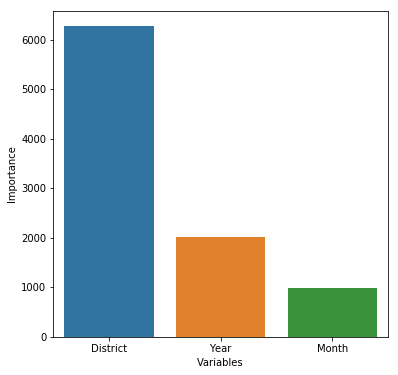

In [106]:
plt.rcParams["figure.figsize"] = [6,6]
imp_df =pd.DataFrame([bst_final.get_score(importance_type='gain')]).T.sort_values([0],ascending = False)
imp = sns.barplot(x = imp_df.index, y = imp_df[0])
imp.set_ylabel('Importance')
imp.set_xlabel('Variables')

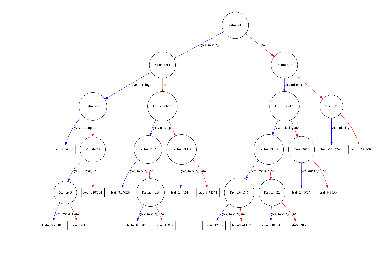

In [107]:
plot_tree(bst_final,num_trees=3)

### 5.7 Prediction and Model accuracy

In [108]:
### Residual Mean squared
### R^2 value

print("Test data RMSE: ",np.sqrt(mean_squared_error(test_data['Cops_required'].values, bst_final.predict(dtest))))
print("Test data R2: ",r2_score(test_data['Cops_required'].values, bst_final.predict(dtest)))

Test data RMSE:  9.862622886946172
Test data R2:  0.9053724266153833


#### Actual vs. Predicted Plot

In [109]:
## Adjusting the plot size
plt.rcParams["figure.figsize"] = [14,6]

Text(0,0.5,'Cops Required')

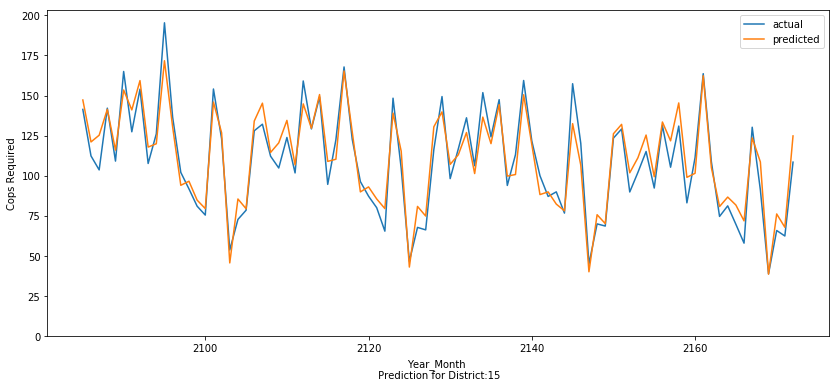

In [110]:
final_prediction = bst_final.predict(dtest)

## Final Predictions 
final_prediction = final_prediction
#[test_data.District == 1]
actual = test_data
#.loc[test_data.District == 1,:]
actual_vals = actual['Cops_required'].values

labs = actual.iloc[:,0:2].apply(lambda x: str(x[0])+"_"+str(x[1]),axis = 1)

## Plot
line = sns.lineplot(actual.index,actual_vals,label = 'actual')
line = sns.lineplot(actual.index,final_prediction,label = 'predicted')

axes = line.axes
axes.set_ylim(0,)
axes.set_xlabel("Year_Month \n Prediction for District:15")
axes.set_ylabel("Cops Required")

## 6. Predicting the number of cops deployed for each District

In [111]:
### Reading the police station data

### Predicting the values for next one month

In [112]:
test_future.loc[:,'Prediction'] = bst_final.predict(dfuture)
test_future.groupby(['Year','Month'],as_index = False)['Prediction'].sum()

,Year,Month,Prediction
0,2019,2,2200.458008
1,2019,3,2400.259521
2,2019,4,2517.050781
3,2019,5,2745.116211


### Police officers for 2019

In [113]:
year = 2019
month = 3

In [114]:
cops_prediction = test_future.groupby(['Year','Month','District'],as_index = False)['Prediction'].sum()
cops_prediction = cops_prediction[(cops_prediction.Year == year) & (cops_prediction.Month == month)]

In [115]:
police_offices = pd.read_csv("Police_Stations.csv")
police_offices.DISTRICT = pd.to_numeric(police_offices.DISTRICT,errors='coerce')
final_df = pd.merge(police_offices,cops_prediction,how='left',left_on = 'DISTRICT',right_on='District')

Text(0,0.5,'Number of police officers required')

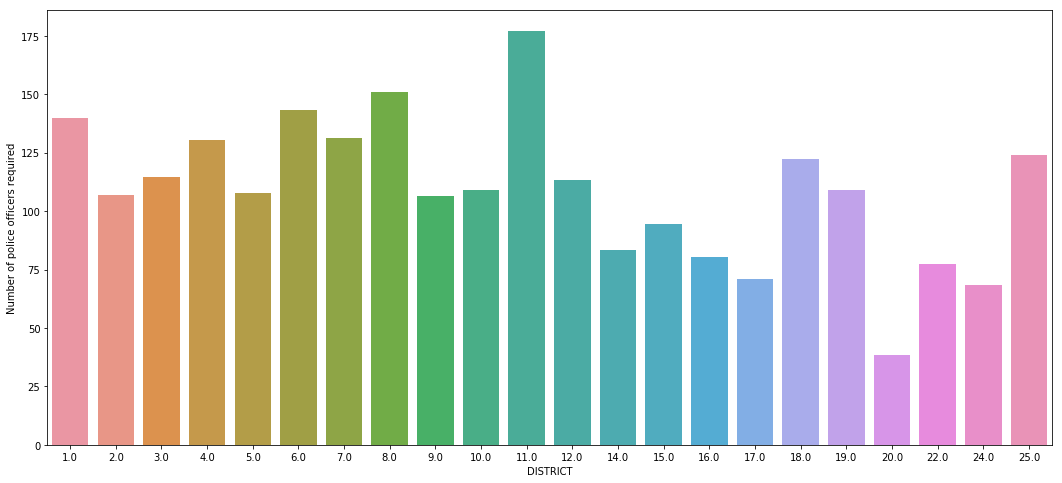

In [116]:
plt.rcParams["figure.figsize"] = [18,8]
final_df = final_df[~final_df.DISTRICT.isna()]
final_df = final_df.sort_values(['DISTRICT'])
bar = sns.barplot(x = final_df.DISTRICT,y = final_df.Prediction)

# for index,row in final_df.iterrows():
#     bar.text(row.DISTRICT,row.Prediction,round(row.Prediction))

bar.set_ylabel('Number of police officers required')

In [117]:
import folium
from folium import plugins

In [118]:
lat_long_matrix = final_df.loc[~final_df.DISTRICT.isna(),['LATITUDE','LONGITUDE','Prediction']].as_matrix()

In [119]:
m = folium.Map([41.8781, -87.6298], zoom_start=10)
plugins.MarkerCluster(lat_long_matrix).add_to(m)
m